In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.lines as mlines
from collections import Counter

from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive as NEA

In [3]:
# Absolute Magnitude Function
def calc_abs_mag(Vmag, distance):
    '''Calculates the absolute magnitude.

        Parameters
        ----------
        Vmag: The apparent magnitude of the star as seen from Earth.
        distance: The distance of the star from Earth in parsecs.

        Returns
        -------
        float: The absolute magnitude of the star.'''
    
    return Vmag - 5 * np.log10(distance/10)

In [5]:
# Load in the stellar data from the Nasa Exoplanet Archive
data = NEA.query_criteria(
    table='stellarhosts',
    select='st_teff, st_rad, st_spectype, sy_vmag, sy_dist'
)

In [13]:
# Mask any NaN values in each column used
stars = data.to_pandas()
mask = (
    stars["st_teff"].notna() &
    stars["st_rad"].notna() &
    stars["st_spectype"].notna() &
    stars["sy_vmag"].notna() &
    stars["sy_dist"].notna()
)

teffs = stars["st_teff"][mask]
rads = stars["st_rad"][mask]
spectypes = stars["st_spectype"][mask]
vmags = stars["sy_vmag"][mask]
distances = stars["sy_dist"][mask]

# Generate absolute magnitude
abs_mags = calc_abs_mag(vmags, distances)

# Calculate stellar luminosity as a ratio of the Sun's luminosity
lums = 100.4 * (4.85 - abs_mags)

# Calculate the B-V color index
b_v = -0.865 + 8540 / teffs

# Function to extract main spectral class
def extract_main_class(spectype):
    '''Extracts the main spectral class (O, B, A, F, G, K, M) from a spectral type string.

        Parameters
        ----------
        spectype: The spectral type string of the star (e.g., 'G2V', 'M1').

        Returns
        -------
        str or None: The main spectral class as a single uppercase letter, or None if not found.'''

    if isinstance(spectype, str):
        match = re.match(r'\s*([OBAFGKM])', spectype.upper())
        if match:
            return match.group(1)
    return None

# Apply to the filtered spectral types
main_classes = spectypes.apply(extract_main_class).dropna()

# Count occurrences
class_counts = Counter(main_classes)
print("Spectral Class Counts:")
for spec_class, count in class_counts.items():
    print(f"{spec_class}: {count}")

Spectral Class Counts:
M: 367
F: 204
K: 394
B: 3
G: 483
A: 12


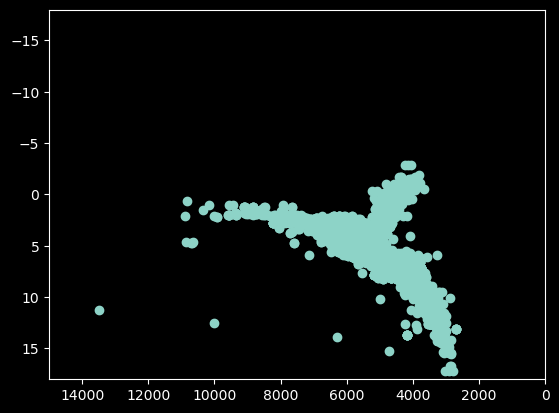

In [17]:
# Initial plot using only temperature and absolute magnitude
plt.scatter(teffs, abs_mags)
plt.xlim(15000, 0)
plt.ylim(18, -18)
plt.show()

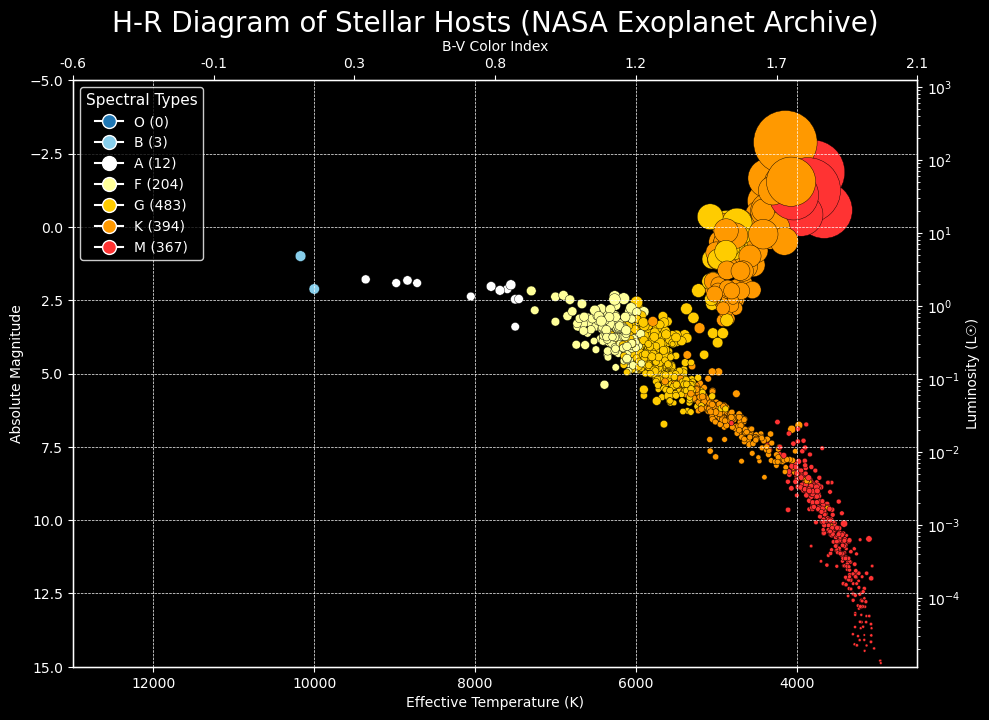

In [33]:
# Align Data
common_index = main_classes.dropna().index.intersection(abs_mags.index).intersection(teffs.index).intersection(lums.index)
main_classes = main_classes[common_index]
abs_mags = abs_mags[common_index]
teffs = teffs[common_index]
lums = lums[common_index]
b_v = b_v[common_index]
rads = rads[common_index]

# Set up the dark background
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(10, 7))
fig.patch.set_facecolor('black')
ax1.set_facecolor('black')

# Color mapping for spectral types
color_map = {
    'O': '#1f77b4',    # blue
    'B': '#87ceeb',    # light blue
    'A': '#ffffff',    # white
    'F': '#ffff99',    # light yellow
    'G': '#ffcc00',    # gold
    'K': '#ff9900',    # orange
    'M': '#ff3333',    # red
}

# Scatter plot
scatter = ax1.scatter(teffs, abs_mags, c=main_classes.map(color_map), s=25*rads, edgecolor='k', linewidth=0.3)

# Primary Axes Labels and Limits
ax1.set_xlabel('Effective Temperature (K)', color='white')
ax1.set_ylabel('Absolute Magnitude', color='white')
ax1.tick_params(axis='both', colors='white')
ax1.set_xlim([13000, 2500])
ax1.set_ylim([15, -5])

# Secondary Y-Axis: Luminosity
ax2 = ax1.twinx()
ax2.set_ylabel('Luminosity (L☉)', color='white')
ax2.set_yscale('log')

# Dynamically align luminosity scale to absolute magnitude range
mag_min = abs_mags.min()
mag_max = abs_mags.max()
ax2.set_ylim([
    10**((mag_max - 4.85) / -2.5),
    10**((mag_min - 4.85) / -2.5)
])

ax2.tick_params(axis='y', colors='white')

# Secondary X-Axis for B-V Color Index
ax3 = ax1.twiny()
ax3.set_xlabel('B-V Color Index', color='white')
ax3.set_xlim([b_v.min(), b_v.max()])
ax3.set_xticks(np.linspace(b_v.min(), b_v.max(), 7))
ax3.set_xticklabels([f'{x:.1f}' for x in np.linspace(b_v.min(), b_v.max(), 7)], color='white')

# Legend with Spectral Class Counts
class_counts = Counter(main_classes)
legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[spec], markersize=10,
                  label=f'{spec} ({class_counts.get(spec, 0)})')
    for spec in color_map
]
ax1.legend(
    handles=legend_elements,
    loc='upper left',
    title='Spectral Types',
    facecolor='black',
    edgecolor='white',
    fontsize=10,
    frameon=True,
    labelcolor='white',
    title_fontsize=11
)

# Grid and Border Styling
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='white')
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_color('white')
    spine.set_linewidth(1)

plt.tight_layout()
plt.title("H-R Diagram of Stellar Hosts (NASA Exoplanet Archive)", fontsize=20)
plt.savefig('hr_diagram.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()